# Imports

In [25]:
import numpy as np
from librosa.feature import melspectrogram
from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers import Lambda
from keras.models import Sequential
from keras.layers import Reshape, Conv1D
import keras.backend as K
from keras import optimizers

In [ ]:
# SOME FUNCTIONS 

def get_sin_from_f(f,sample=348000,Fs=12000):
    x = np.arange(sample)
    return np.sin(2 * np.pi * f * x / Fs)

def normalize(X):
    X -= np.min(X)
    X /= np.ptp(X)
    return X


def logFunc(x):
    return K.log(x)

def my_init(shape,dtype=None):
    x = np.sin(np.linspace(0,shape[0],shape[0])*2*np.pi*10000)
    x = np.repeat(x[:,np.newaxis], n_mels, axis=1)
    x = np.asarray(x[:,np.newaxis,:])
    res = K.constant(x)
    return res

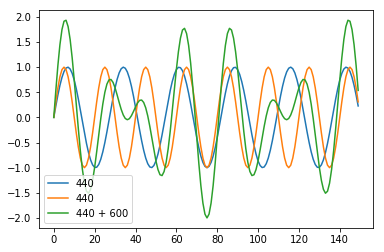

s_sum.s_1 = 173999.99999999942
s_sum.s_2 = 173999.9999999991
s_sum.s_3 = 5.527528351700894e-09


In [166]:
# 2 ondes non-harmoniques

s_1 = get_sin_from_f(440)
s_2 = get_sin_from_f(600)

s_sum = s_1 + s_2

plot_sample = 150

c_1, = plt.plot(s_1[:plot_sample],label='440')
c_2, = plt.plot(s_2[:plot_sample],label='440')
c_3, = plt.plot(s_sum[:plot_sample],label='440 + 600')

plt.legend(handles=[c_1, c_2,c_3])
plt.show()

# Verification orthogonalité
s_3 = get_sin_from_f(601)

print("s_sum.s_1 = {}".format(np.dot(s_sum,s_1)))
print("s_sum.s_2 = {}".format(np.dot(s_sum,s_2)))
print("s_sum.s_3 = {}".format(np.dot(s_sum,s_3)))


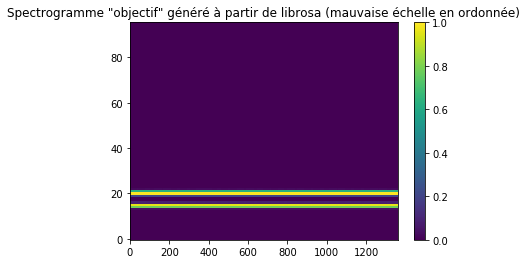

In [169]:
n_mels = 96

spec_test =melspectrogram(s_sum, sr=12000,n_mels=n_mels,n_fft=512,hop_length=256)

plt.imshow(normalize(spec_test),origin='low',aspect='auto')
plt.title('Spectrogramme "objectif" généré à partir de librosa (mauvaise échelle en ordonnée)')
plt.colorbar()

In [171]:
# MODEL

model = Sequential()

model.add(Reshape((348000,1),input_shape=(1,348000)))

model.add(Conv1D(filters=n_mels,
                 kernel_size=512,
                 strides=256,
                 padding="same",
                 kernel_initializer='zeros',
                 bias_initializer='zeros'))

model.add(Reshape((n_mels,1360)))

# OPTIMIZER

opt = optimizers.Adam(lr=0.001)

# LOSS

def my_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))

model.compile(loss=my_loss, optimizer=opt)

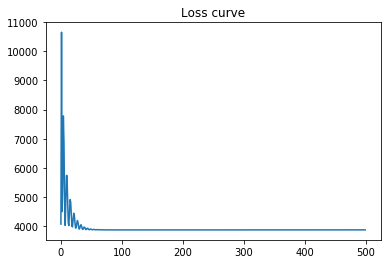

In [172]:
src_test = s_sum[np.newaxis,np.newaxis,:]

history = model.fit(src_test, spec_test[np.newaxis,...], epochs=500, batch_size=1,verbose=0)
plt.plot(history.history.get('loss'))
plt.title('Loss curve')

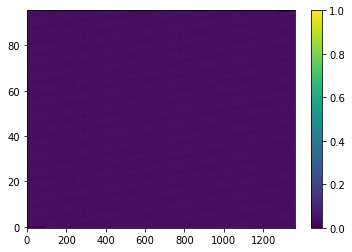

In [173]:
# Visualisation output
spec_model = model.predict(src_test)[0,:,:]
plt.imshow(spec_model,origin='low',aspect='auto',vmin=0, vmax=1)
plt.colorbar()

(512, 1, 96)


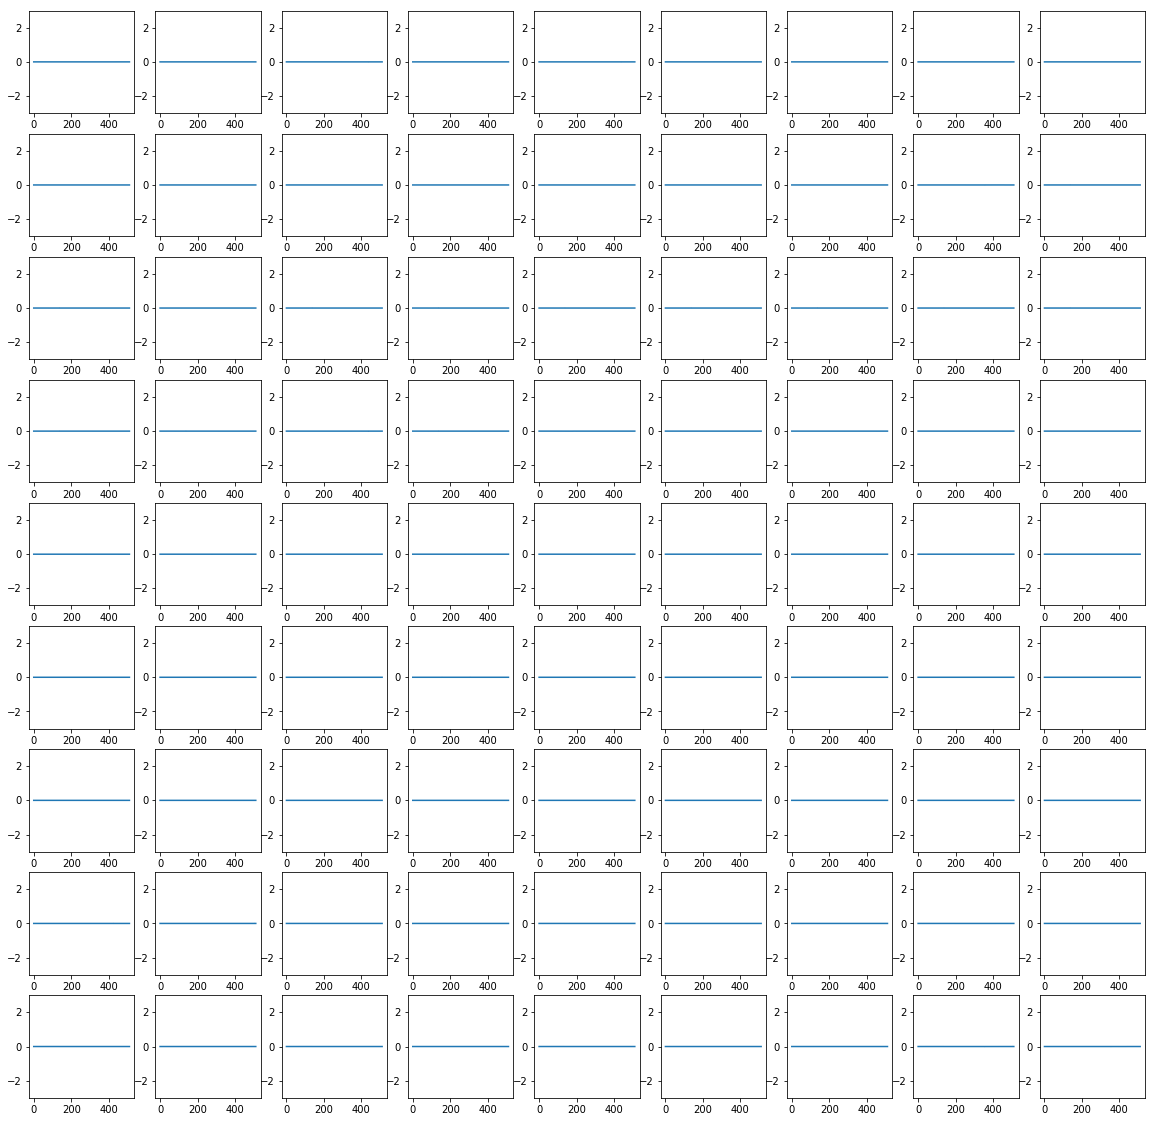

In [180]:
# Kernels plot

W = model.layers[1].get_weights()
plt.figure(figsize=(20,20))
n = 9

print(W[0].shape)
for i in range(n**2):
    plt.subplot(n,n,i+1)
    plt.plot(W[0][:,:,i])
    plt.ylim([-3,3])
